In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
Step = namedtuple('Step','cur_state action')

import local_utils as utils
from mdp import gridworld
from mdp import value_iteration
from mdp import frozenlake
from maxent_irl import *

In [2]:
def generate_demonstrations(game, policy, n_trajs=100, max_len_traj=100, rand_start=False, start_pos=(0,0)):

  trajs = []
  for i in range(n_trajs):
    
    if rand_start:
      start_pos = game.get_random_position()

    episode = []
    cur_state, action, next_state, reward, is_done = game.reset(start_pos)
    for j in range(max_len_traj):
        if is_done:
            episode.append(Step(cur_state=game.pos2idx(next_state), action=None))
            break
        cur_state = next_state
        new_cur_state, action, next_state, reward, is_done = game.step(int(policy[game.pos2idx(cur_state)]))
        episode.append(Step(cur_state=game.pos2idx(cur_state), action=action))
    trajs.append(episode)
  return trajs

In [3]:
def main(true_rewards, game, title, GAMMA=0.8, ACT_RAND=0.3, N_TRAJS=100, MAX_L_TRAJ=100, T_HORIZON=20, RAND_START=False, LEARNING_RATE=0.01, N_ITERS=20, order='F'):
    H, W = true_rewards.shape
    N_STATES = H * W
    
    true_rewards_vec = np.reshape(true_rewards, H*W, order='F')
    P_a = game.get_transition_mat()
    values_gt, policy_gt = value_iteration.calculate_values_and_policy(P_a, true_rewards_vec, GAMMA, error=0.01, deterministic=True)
        
    # use identity matrix as feature
    feat_map = np.eye(N_STATES)

#     np.random.seed(1)
    trajs = generate_demonstrations(game, policy_gt, n_trajs=N_TRAJS, max_len_traj=MAX_L_TRAJ, rand_start=RAND_START)
    recovered_rewards = maxent_irl(feat_map, P_a, trajs, LEARNING_RATE, N_ITERS, T_HORIZON, f"{title}_{H}x{W}")

    values, policy = value_iteration.calculate_values_and_policy(P_a, recovered_rewards, GAMMA, error=0.01, deterministic=True)
    
    plot_table(H, W, true_rewards, values_gt, policy_gt, recovered_rewards, values, policy, game.dirs, f"{title}_{H}x{W}", order)
#     return values_gt, policy_gt, recovered_rewards, values, policy


In [4]:
def plot_table(H, W, rmap_gt, values_gt, policy_gt, new_rewards, new_values, new_policy, dirs, title, order):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
    fig.set_dpi(150)
    utils.plot_rewards_map(rmap_gt, fig, ax[0, 0], f"{title}-groundTruth")
    utils.plot_values_policy_map(np.reshape(values_gt, (H,W), order=order), np.reshape(policy_gt, (H,W), order=order), dirs, fig, ax[0, 1], f"{title}-groundTruth")
    utils.plot_rewards_map(np.reshape(new_rewards, (H,W), order=order), fig, ax[1, 0], f"{title}-recovered")
    utils.plot_values_policy_map(np.reshape(new_values, (H,W), order=order), np.reshape(new_policy, (H,W), order=order), dirs, fig, ax[1, 1], f"{title}-recovered")
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:33<00:00,  3.66it/s]


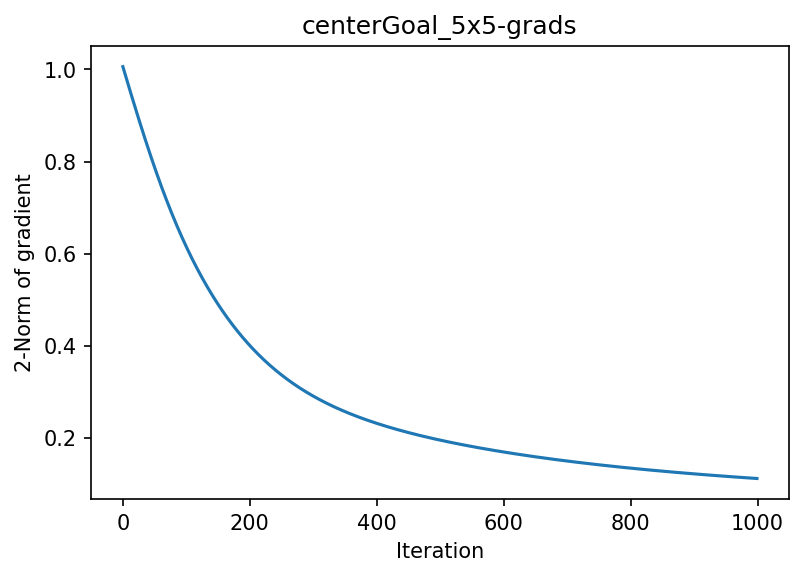

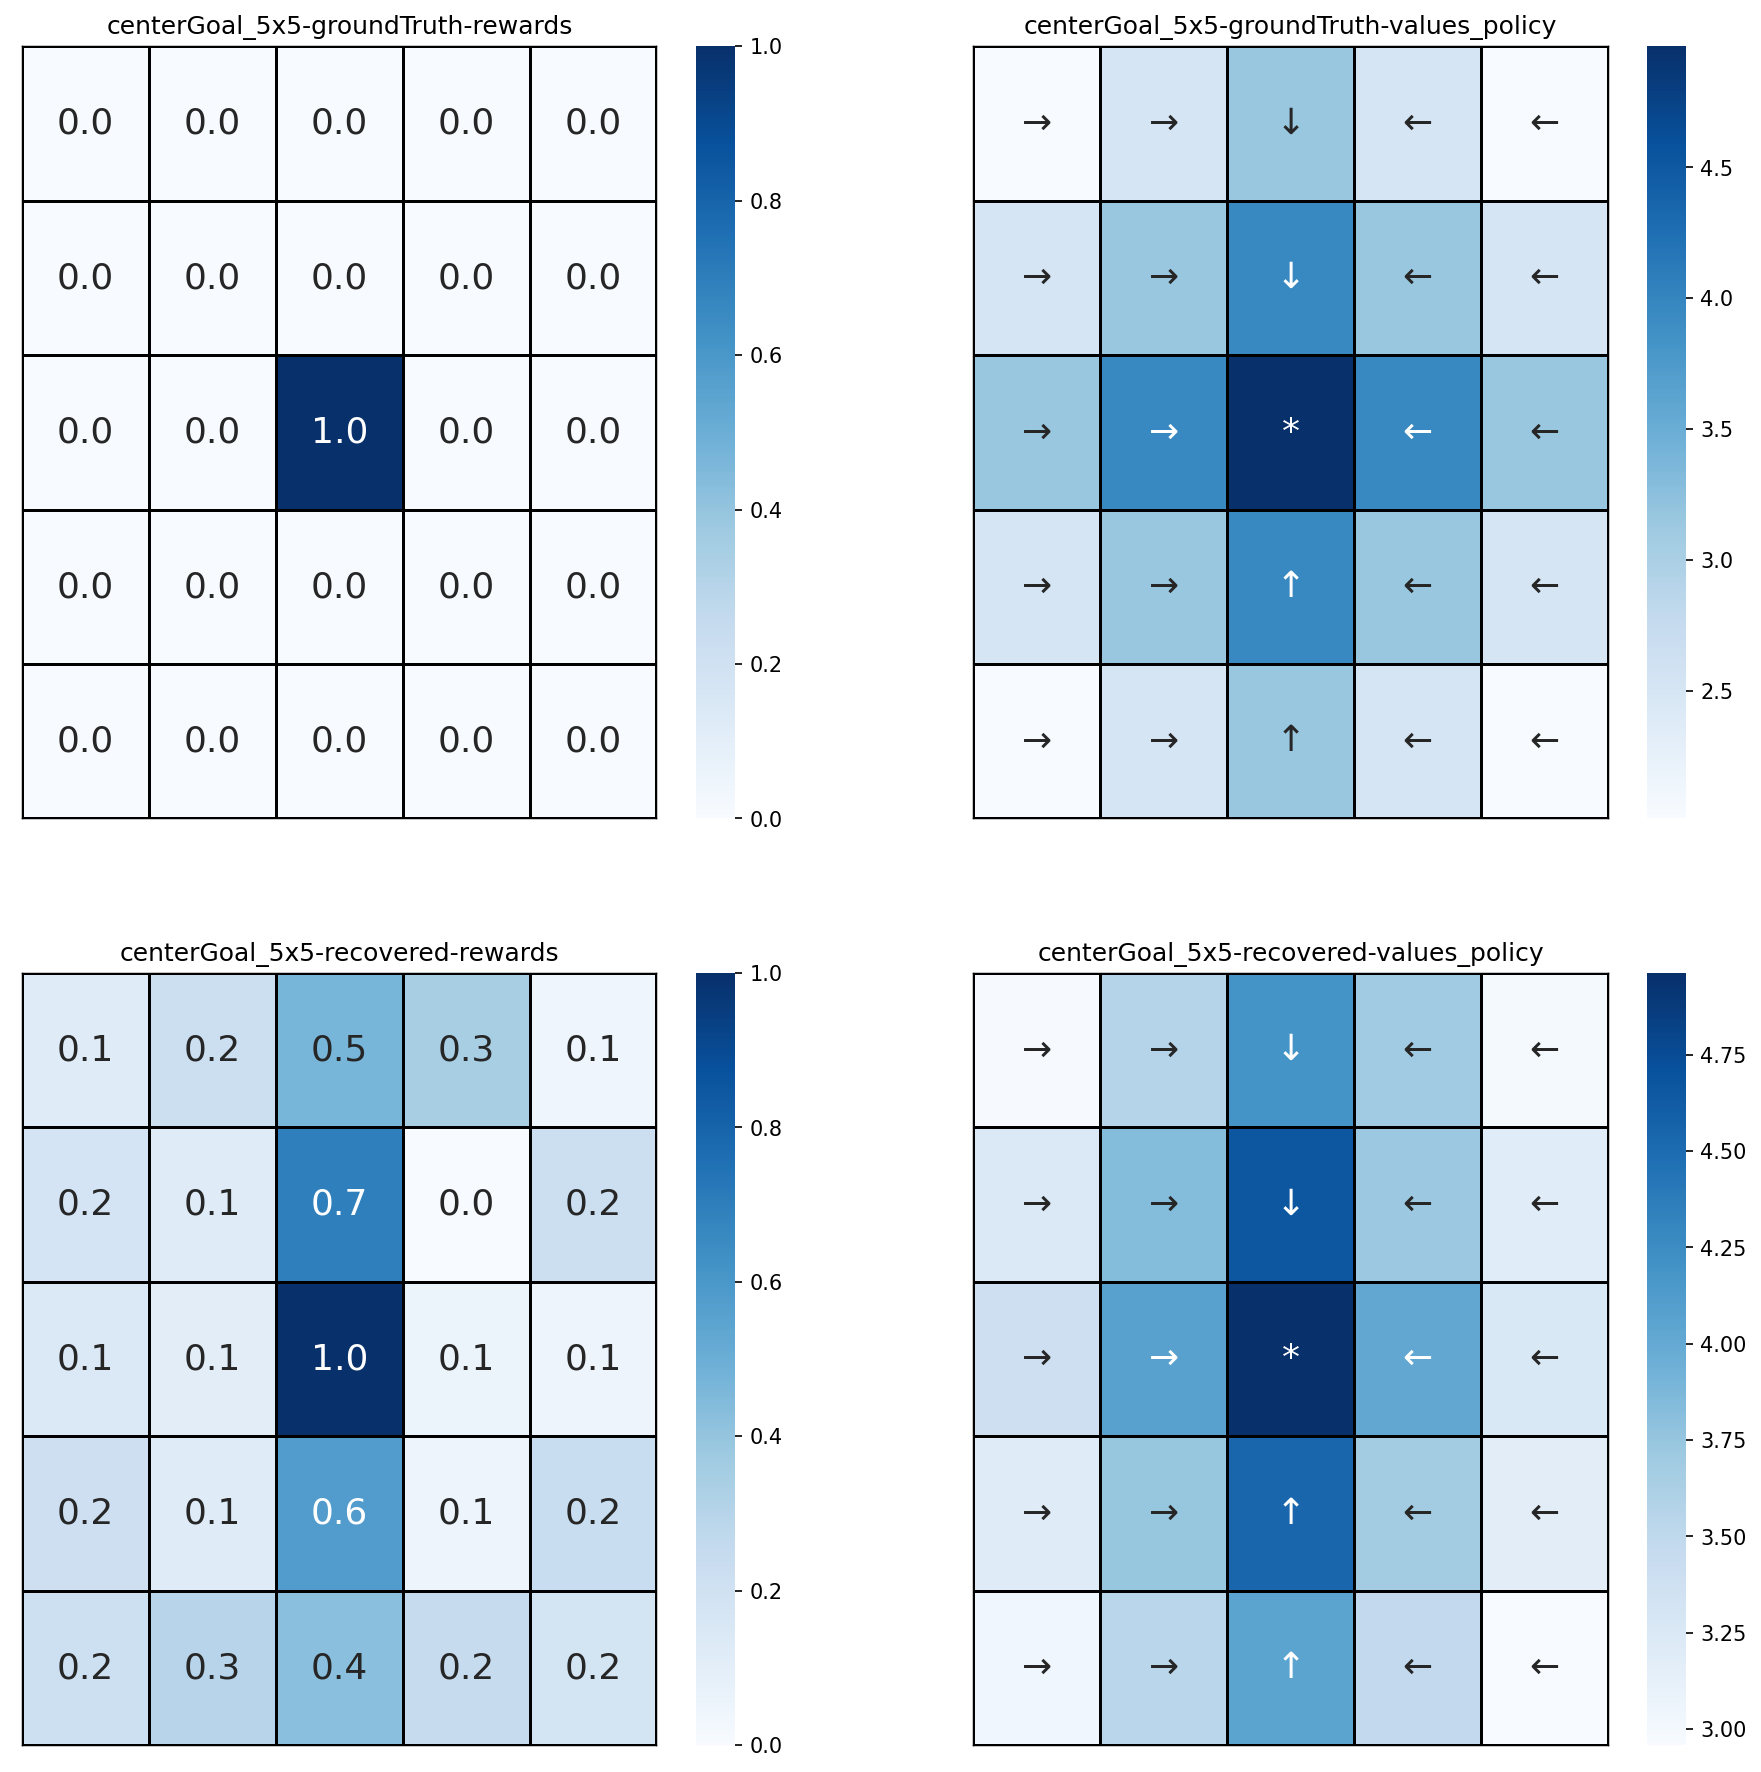

In [5]:
H = 5
W = 5
rmap_gt = np.zeros([H, W])
rmap_gt[H-3, W-3] = +1
ACT_RAND = 0
terminals = {(H-3, W-3)}
gw = gridworld.GridWorld(rmap_gt, terminals, 1 - ACT_RAND)
title = "centerGoal"
main(rmap_gt, gw, title, RAND_START=True, N_TRAJS=1000, N_ITERS=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:50<00:00,  4.33it/s]


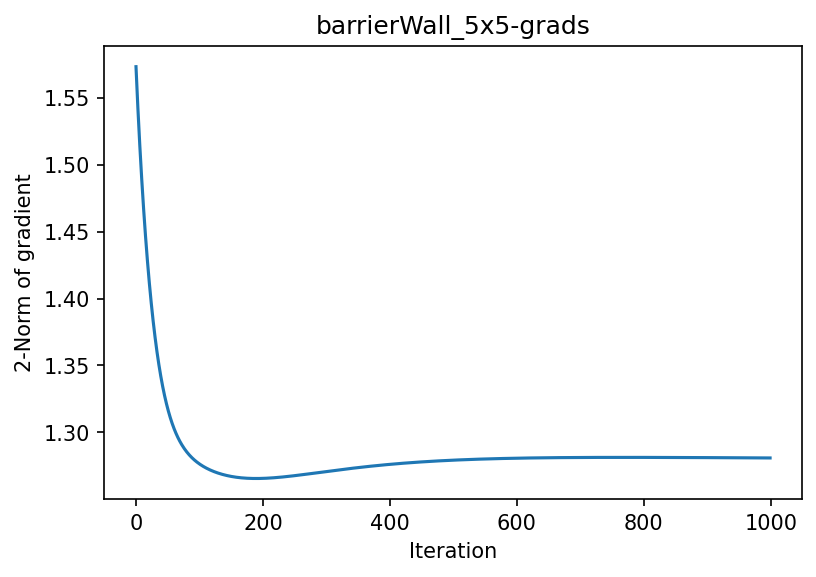

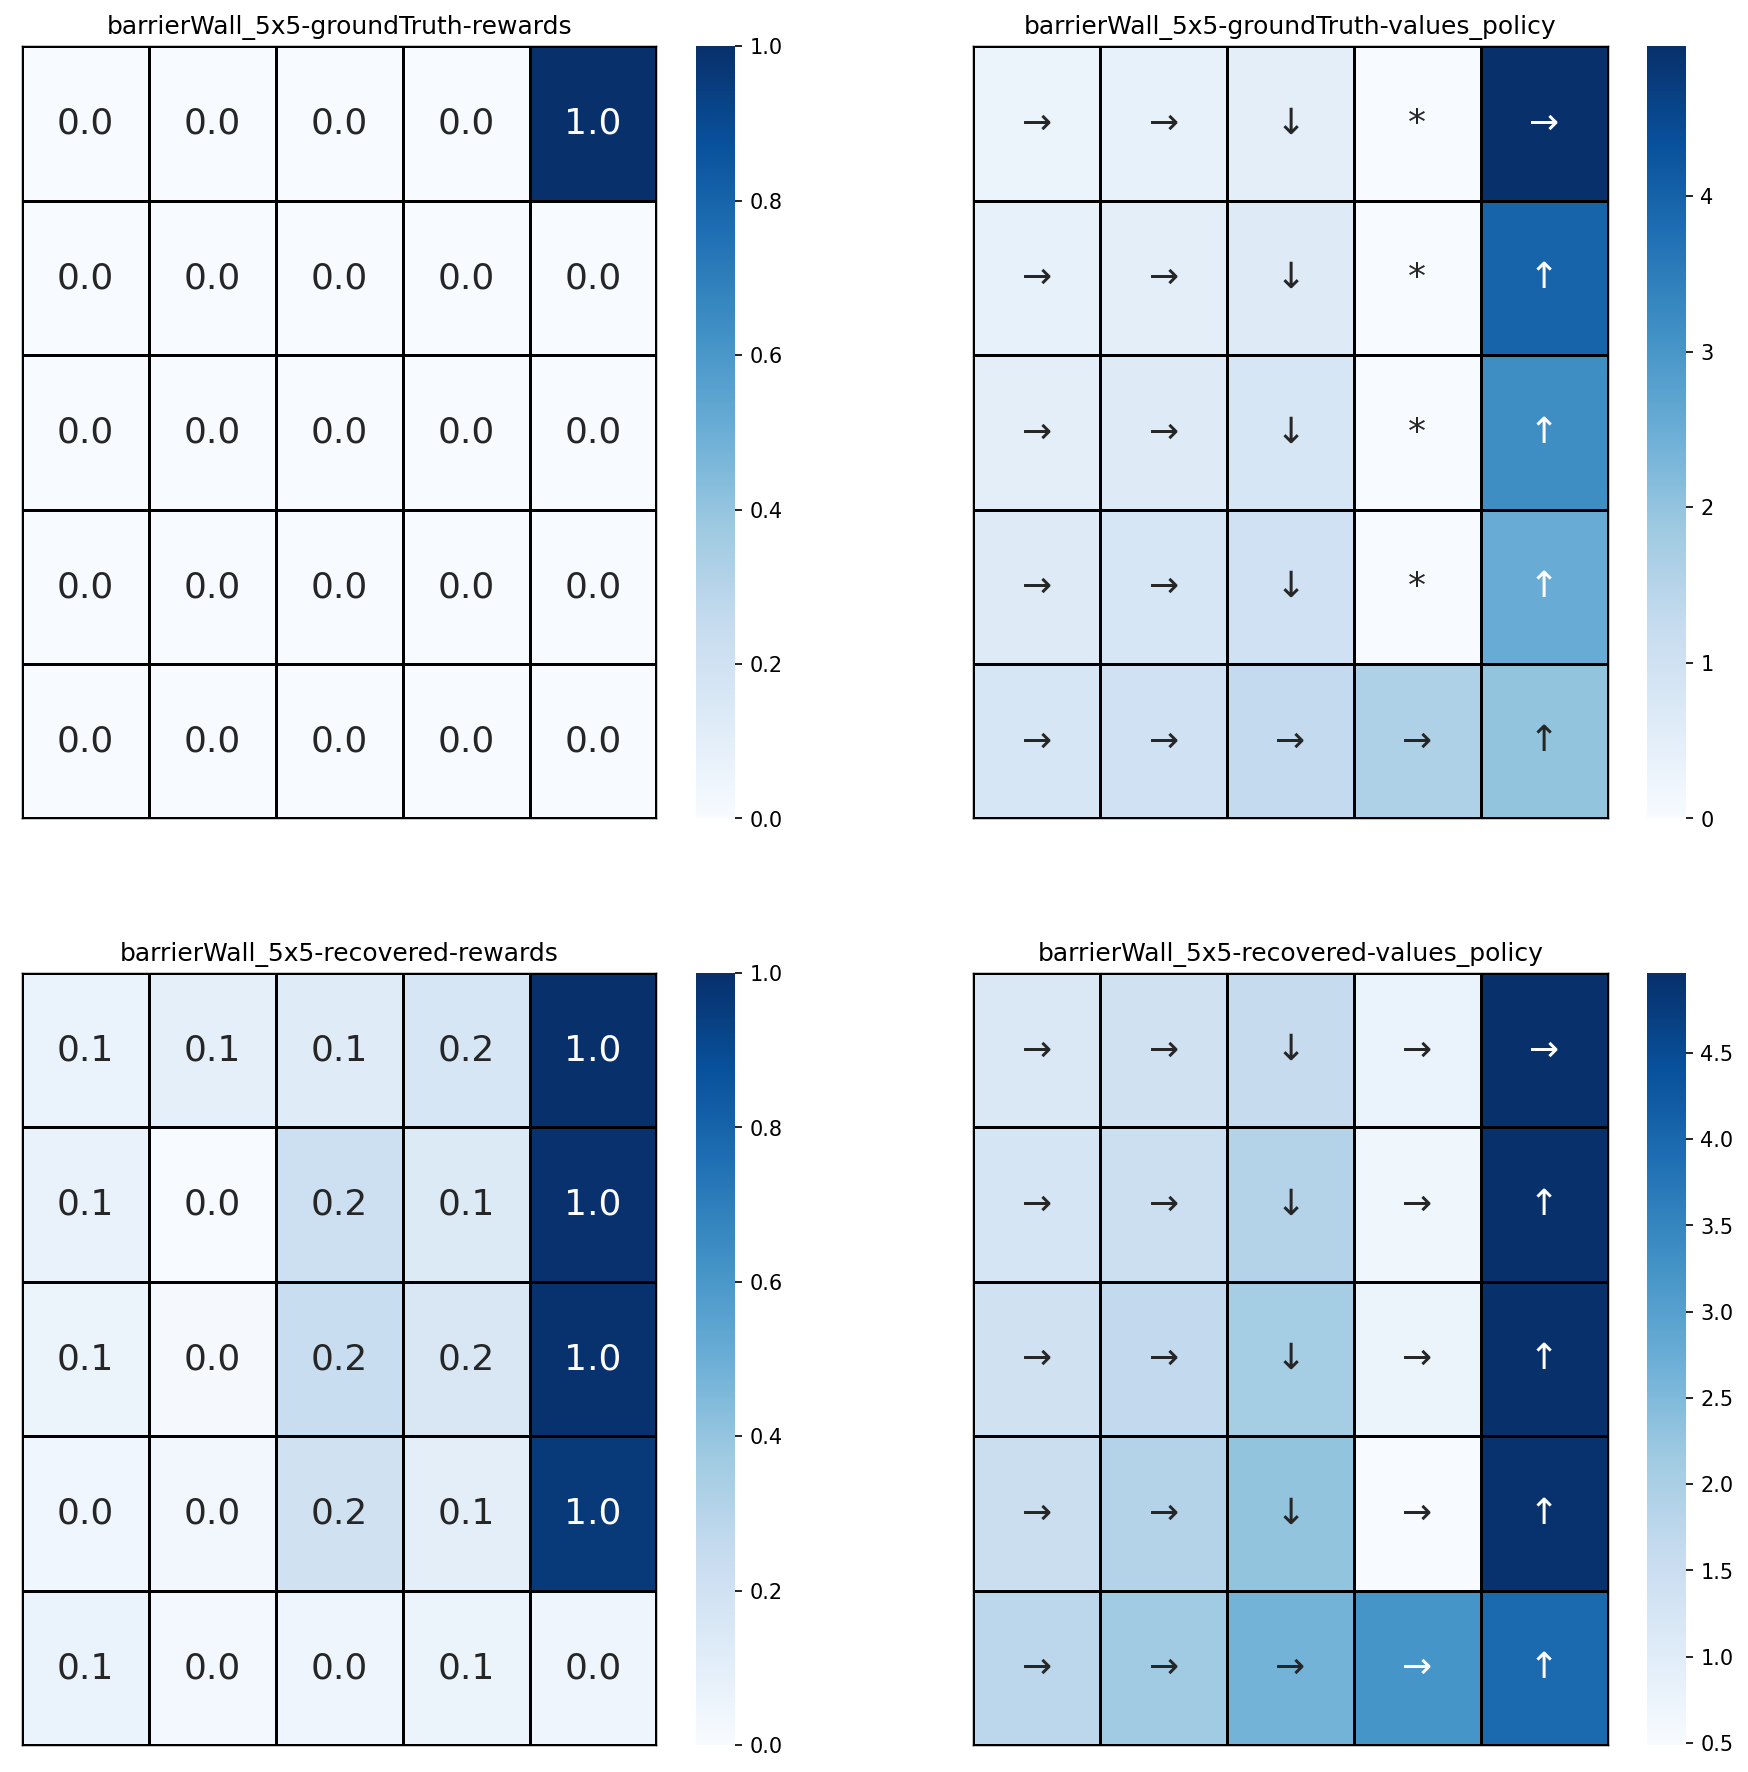

In [5]:
H = 5
W = 5
rmap_gt = np.zeros([H, W])
rmap_gt[0, W-1] = +1
for i in range(H-1):
    rmap_gt[i, W-2] = -1
ACT_RAND = 0
terminals = {(0, W-1)}
gw = gridworld.GridWorld(rmap_gt, terminals, 1 - ACT_RAND)
for i in range(H-1):
    rmap_gt[i, W-2] = 0
title = "barrierWall"
main(rmap_gt, gw, title, RAND_START=True, N_TRAJS=10000, N_ITERS=1000)

---------iteration: 0/1000---------
---------iteration: 100/1000---------
---------iteration: 200/1000---------
---------iteration: 300/1000---------
---------iteration: 400/1000---------
---------iteration: 500/1000---------
---------iteration: 600/1000---------
---------iteration: 700/1000---------
---------iteration: 800/1000---------
---------iteration: 900/1000---------


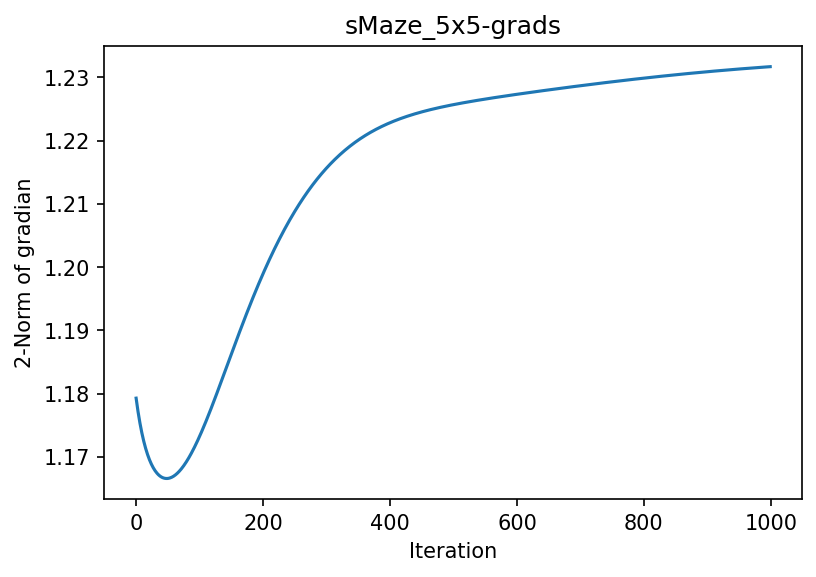

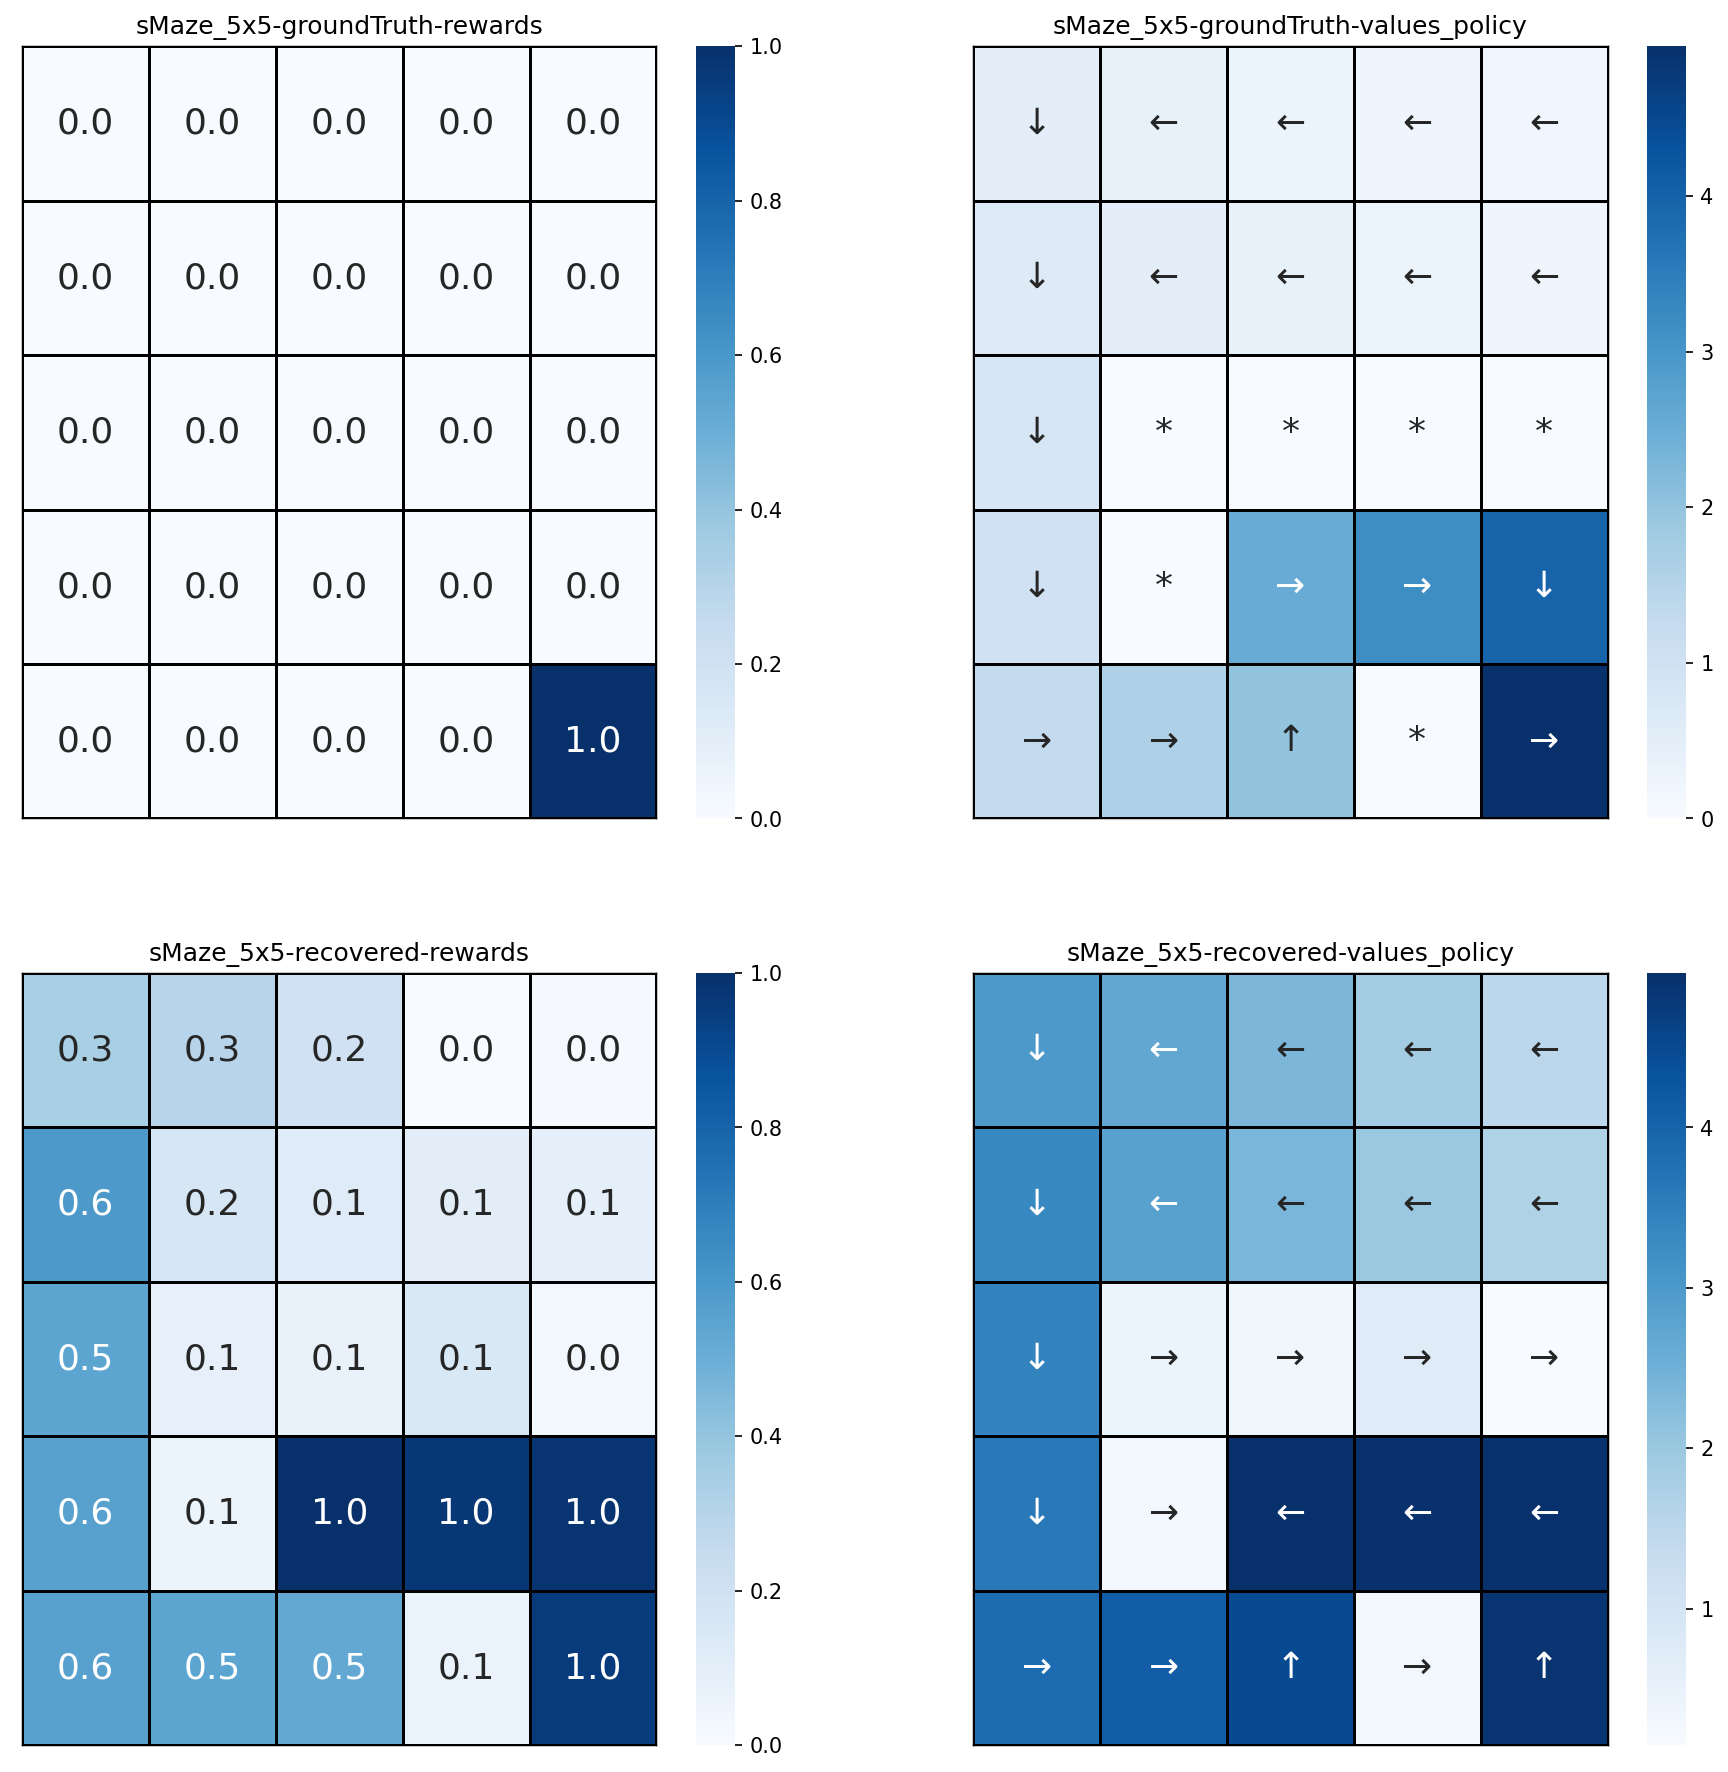

In [20]:
H = 5
W = 5
rmap_gt = np.zeros([H, W])
rmap_gt[H-1, W-1] = +1
walls = [(H-1, W-2), (H-2, W-4), (H-3, W-1), (H-3, W-2), (H-3, W-3), (H-3, W-4)]
for wall in walls:
    rmap_gt[wall[0]][wall[1]] = -1
ACT_RAND = 0
terminals = {(H-1, W-1)}
gw = gridworld.GridWorld(rmap_gt, terminals, 1 - ACT_RAND)
for wall in walls:
    rmap_gt[wall[0]][wall[1]] = 0
title = "sMaze"
main(rmap_gt, gw, title, RAND_START=True, N_TRAJS=10000, N_ITERS=1000)

---------iteration: 0/2000---------
---------iteration: 200/2000---------
---------iteration: 400/2000---------
---------iteration: 600/2000---------
---------iteration: 800/2000---------
---------iteration: 1000/2000---------
---------iteration: 1200/2000---------
---------iteration: 1400/2000---------
---------iteration: 1600/2000---------
---------iteration: 1800/2000---------


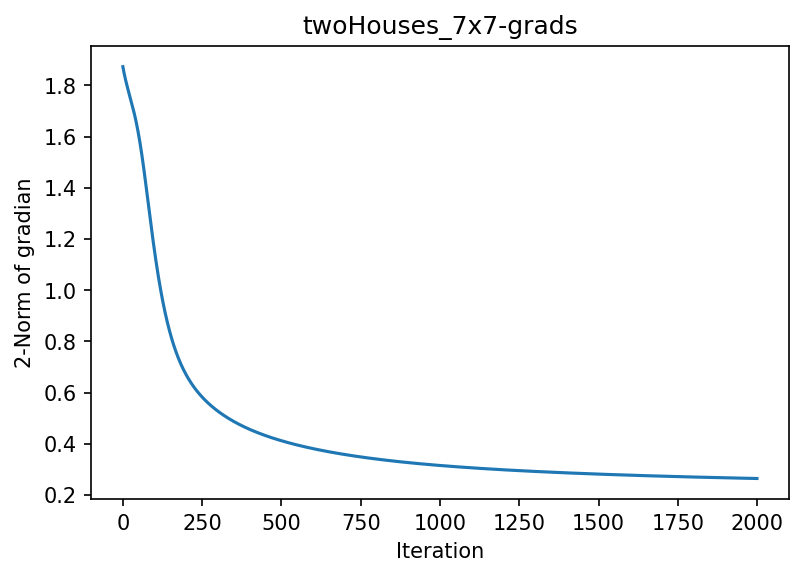

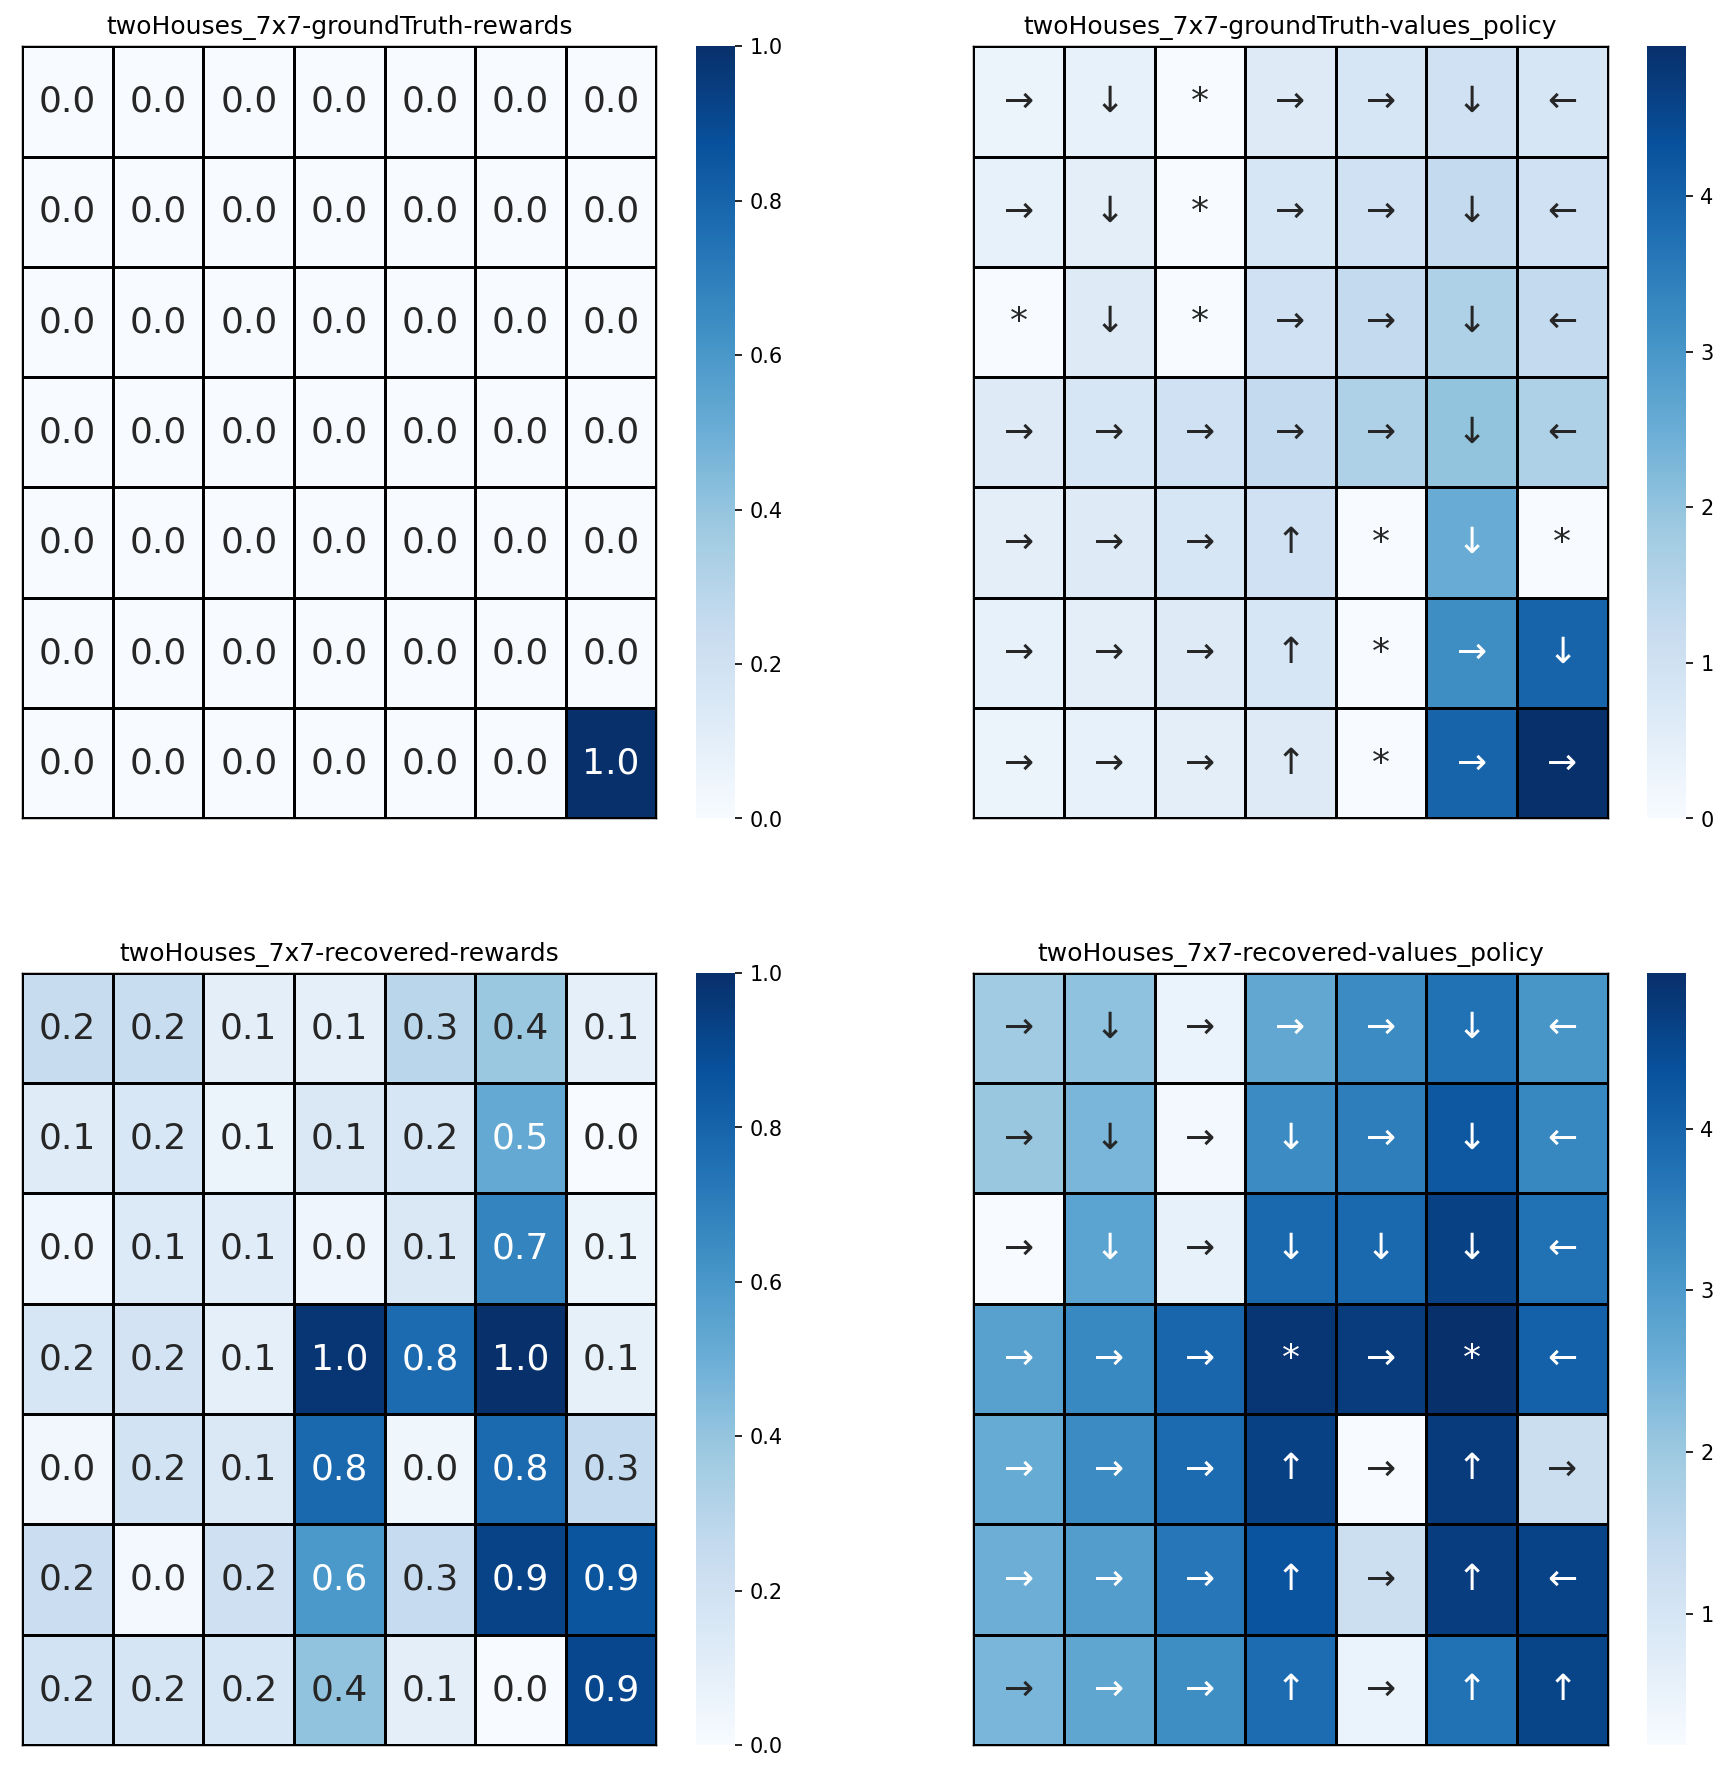

In [21]:
H = 7
W = 7
rmap_gt = np.zeros([H, W])
rmap_gt[H-1, W-1] = +1
walls = [(0, 2), (1, 2), (2, 2), (2, 0), (H-3, W-3), (H-2, W-3), (H-1, W-3), (H-3, W-1)]
for wall in walls:
    rmap_gt[wall[0]][wall[1]] = -1
ACT_RAND = 0
terminals = {(H-1, W-1)}
gw = gridworld.GridWorld(rmap_gt, terminals, 1 - ACT_RAND)
for wall in walls:
    rmap_gt[wall[0]][wall[1]] = 0
title = "twoHouses"
main(rmap_gt, gw, title, RAND_START=True, N_TRAJS=10000, N_ITERS=2000)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [31:31<00:00,  1.06it/s]


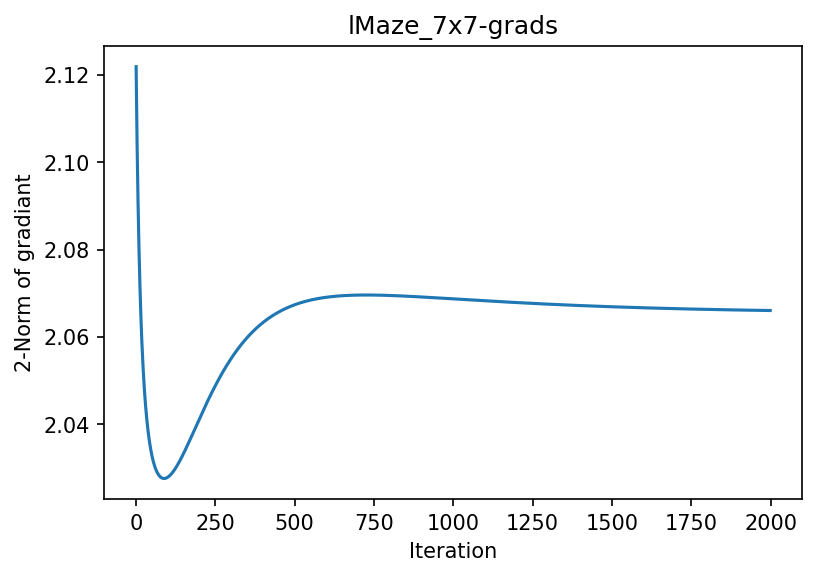

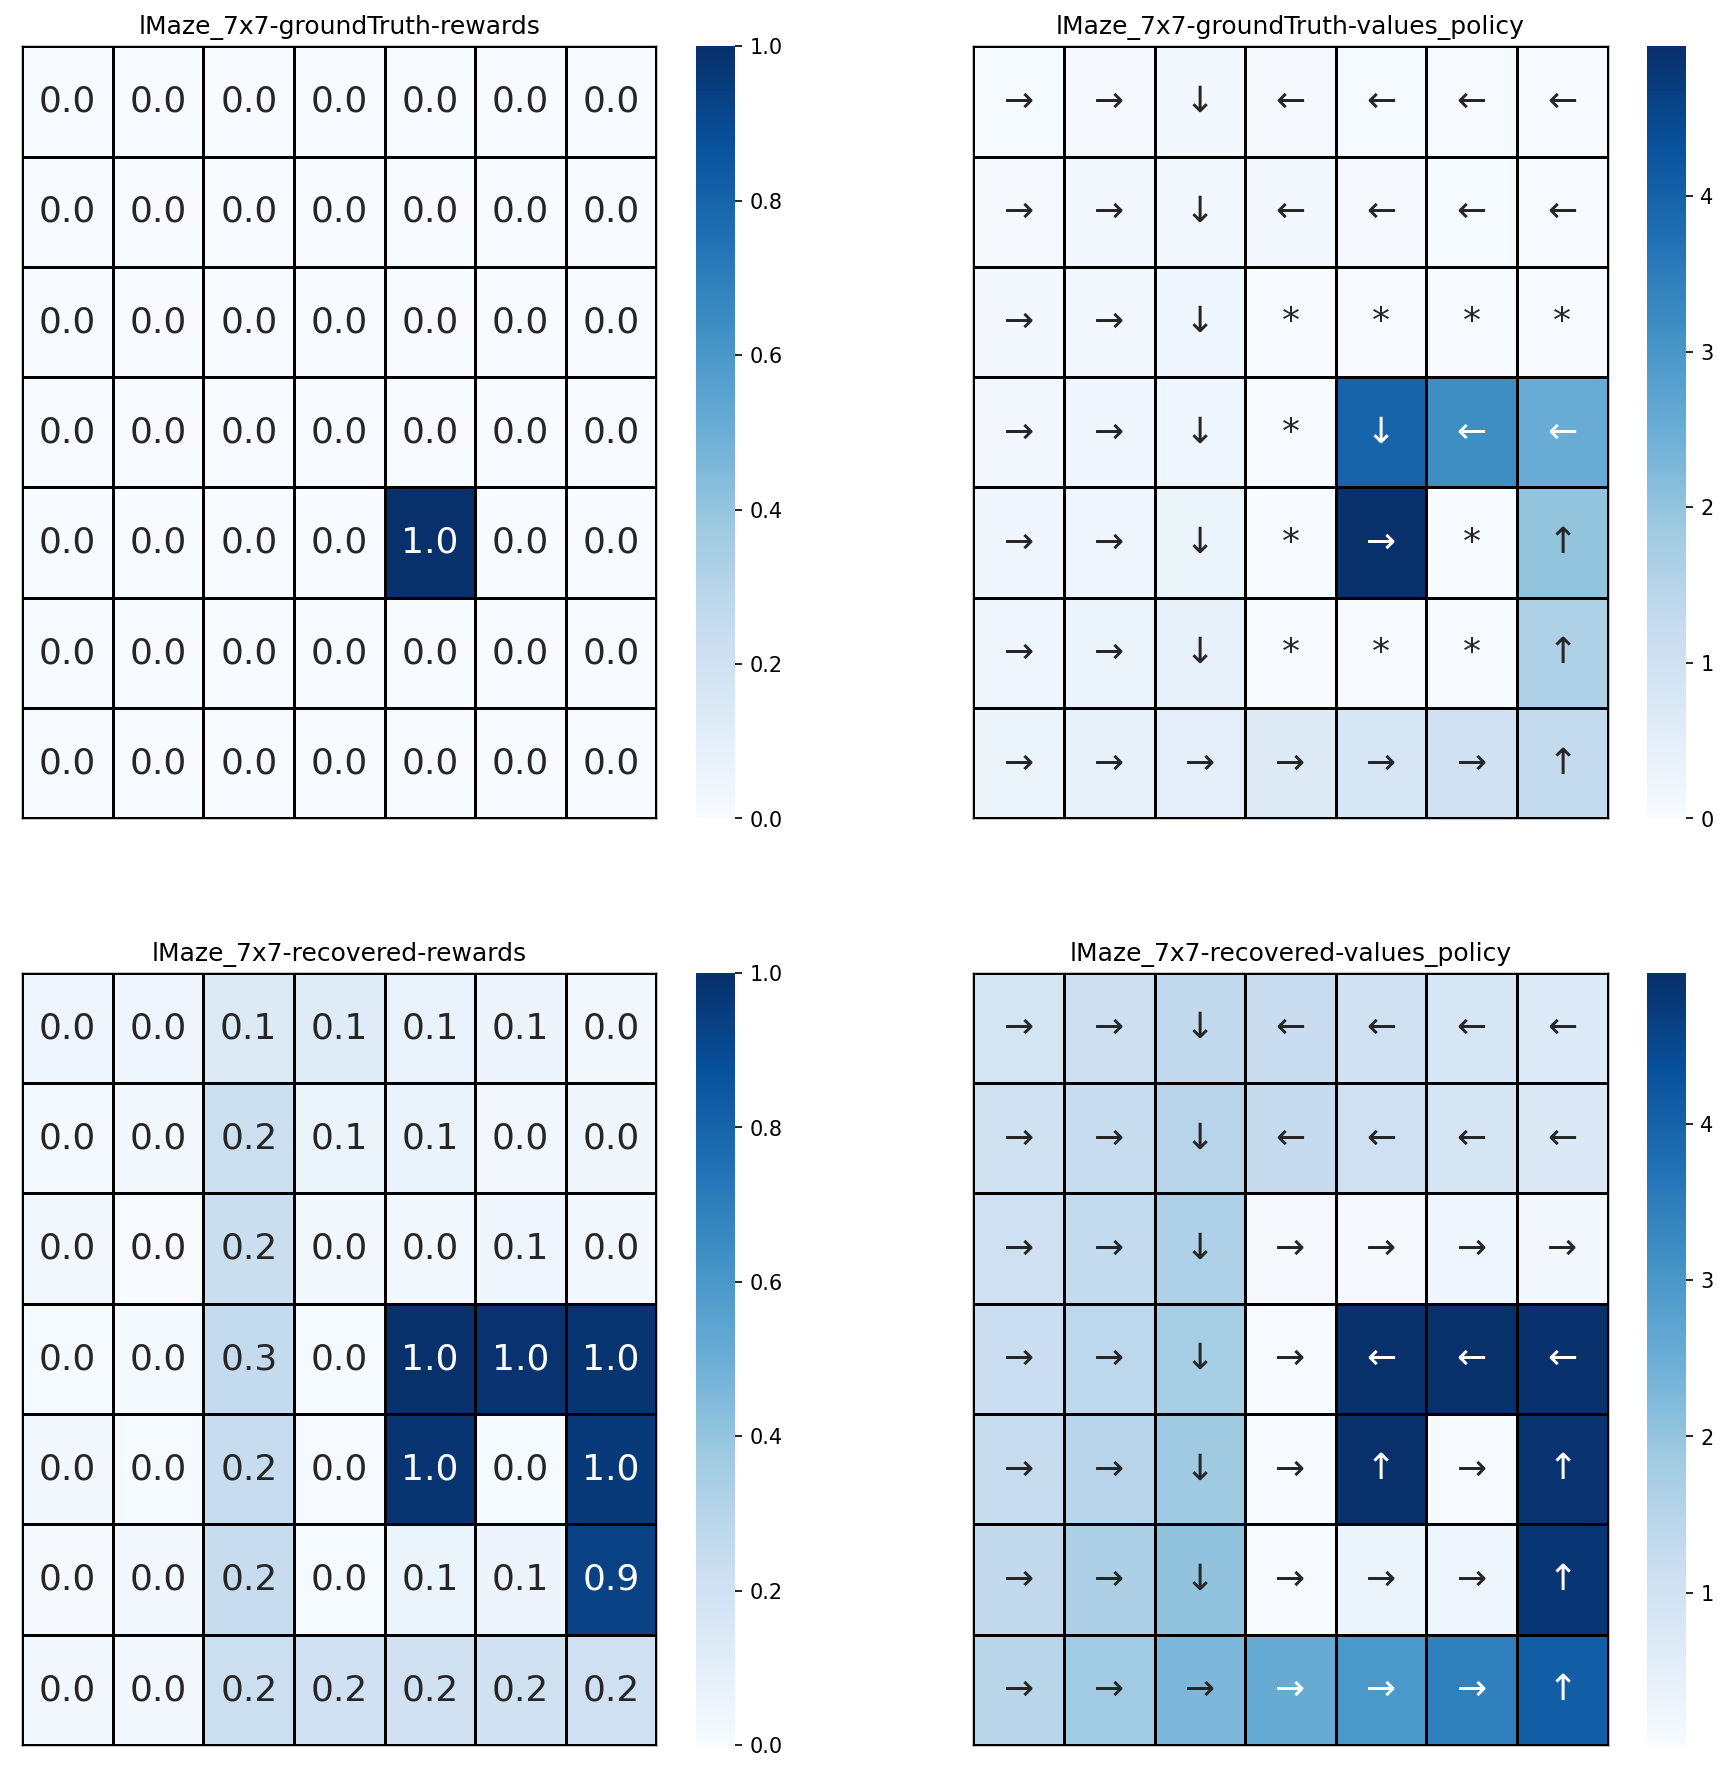

In [6]:
H = 7
W = 7
rmap_gt = np.zeros([H, W])
walls = [(H-5, W-1), (H-5, W-2), (H-5, W-3), (H-5, W-4), (H-4, W-4), (H-3, W-4), (H-2, W-4), (H-2, W-3), (H-2, W-2), (H-3, W-2)]
rmap_gt[H-3, W-3] = +1
for wall in walls:
    rmap_gt[wall[0]][wall[1]] = -1
ACT_RAND = 0
terminals = {(H-3, W-3)}
gw = gridworld.GridWorld(rmap_gt, terminals, 1 - ACT_RAND)
for wall in walls:
    rmap_gt[wall[0]][wall[1]] = 0
title = "lMaze"
main(rmap_gt, gw, title, RAND_START=True, N_TRAJS=10000, N_ITERS=2000)

['SFFF', 'FFFF', 'FFFF', 'FFFG']


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:56<00:00,  8.59it/s]


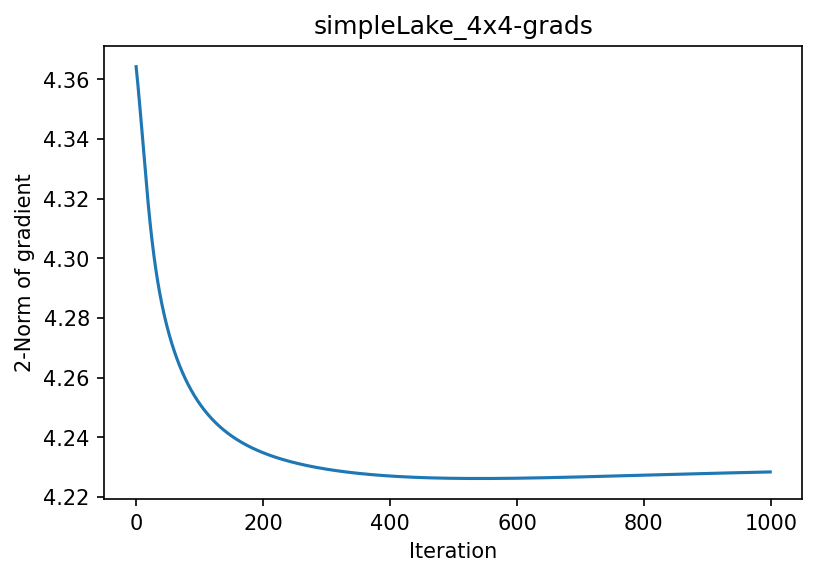

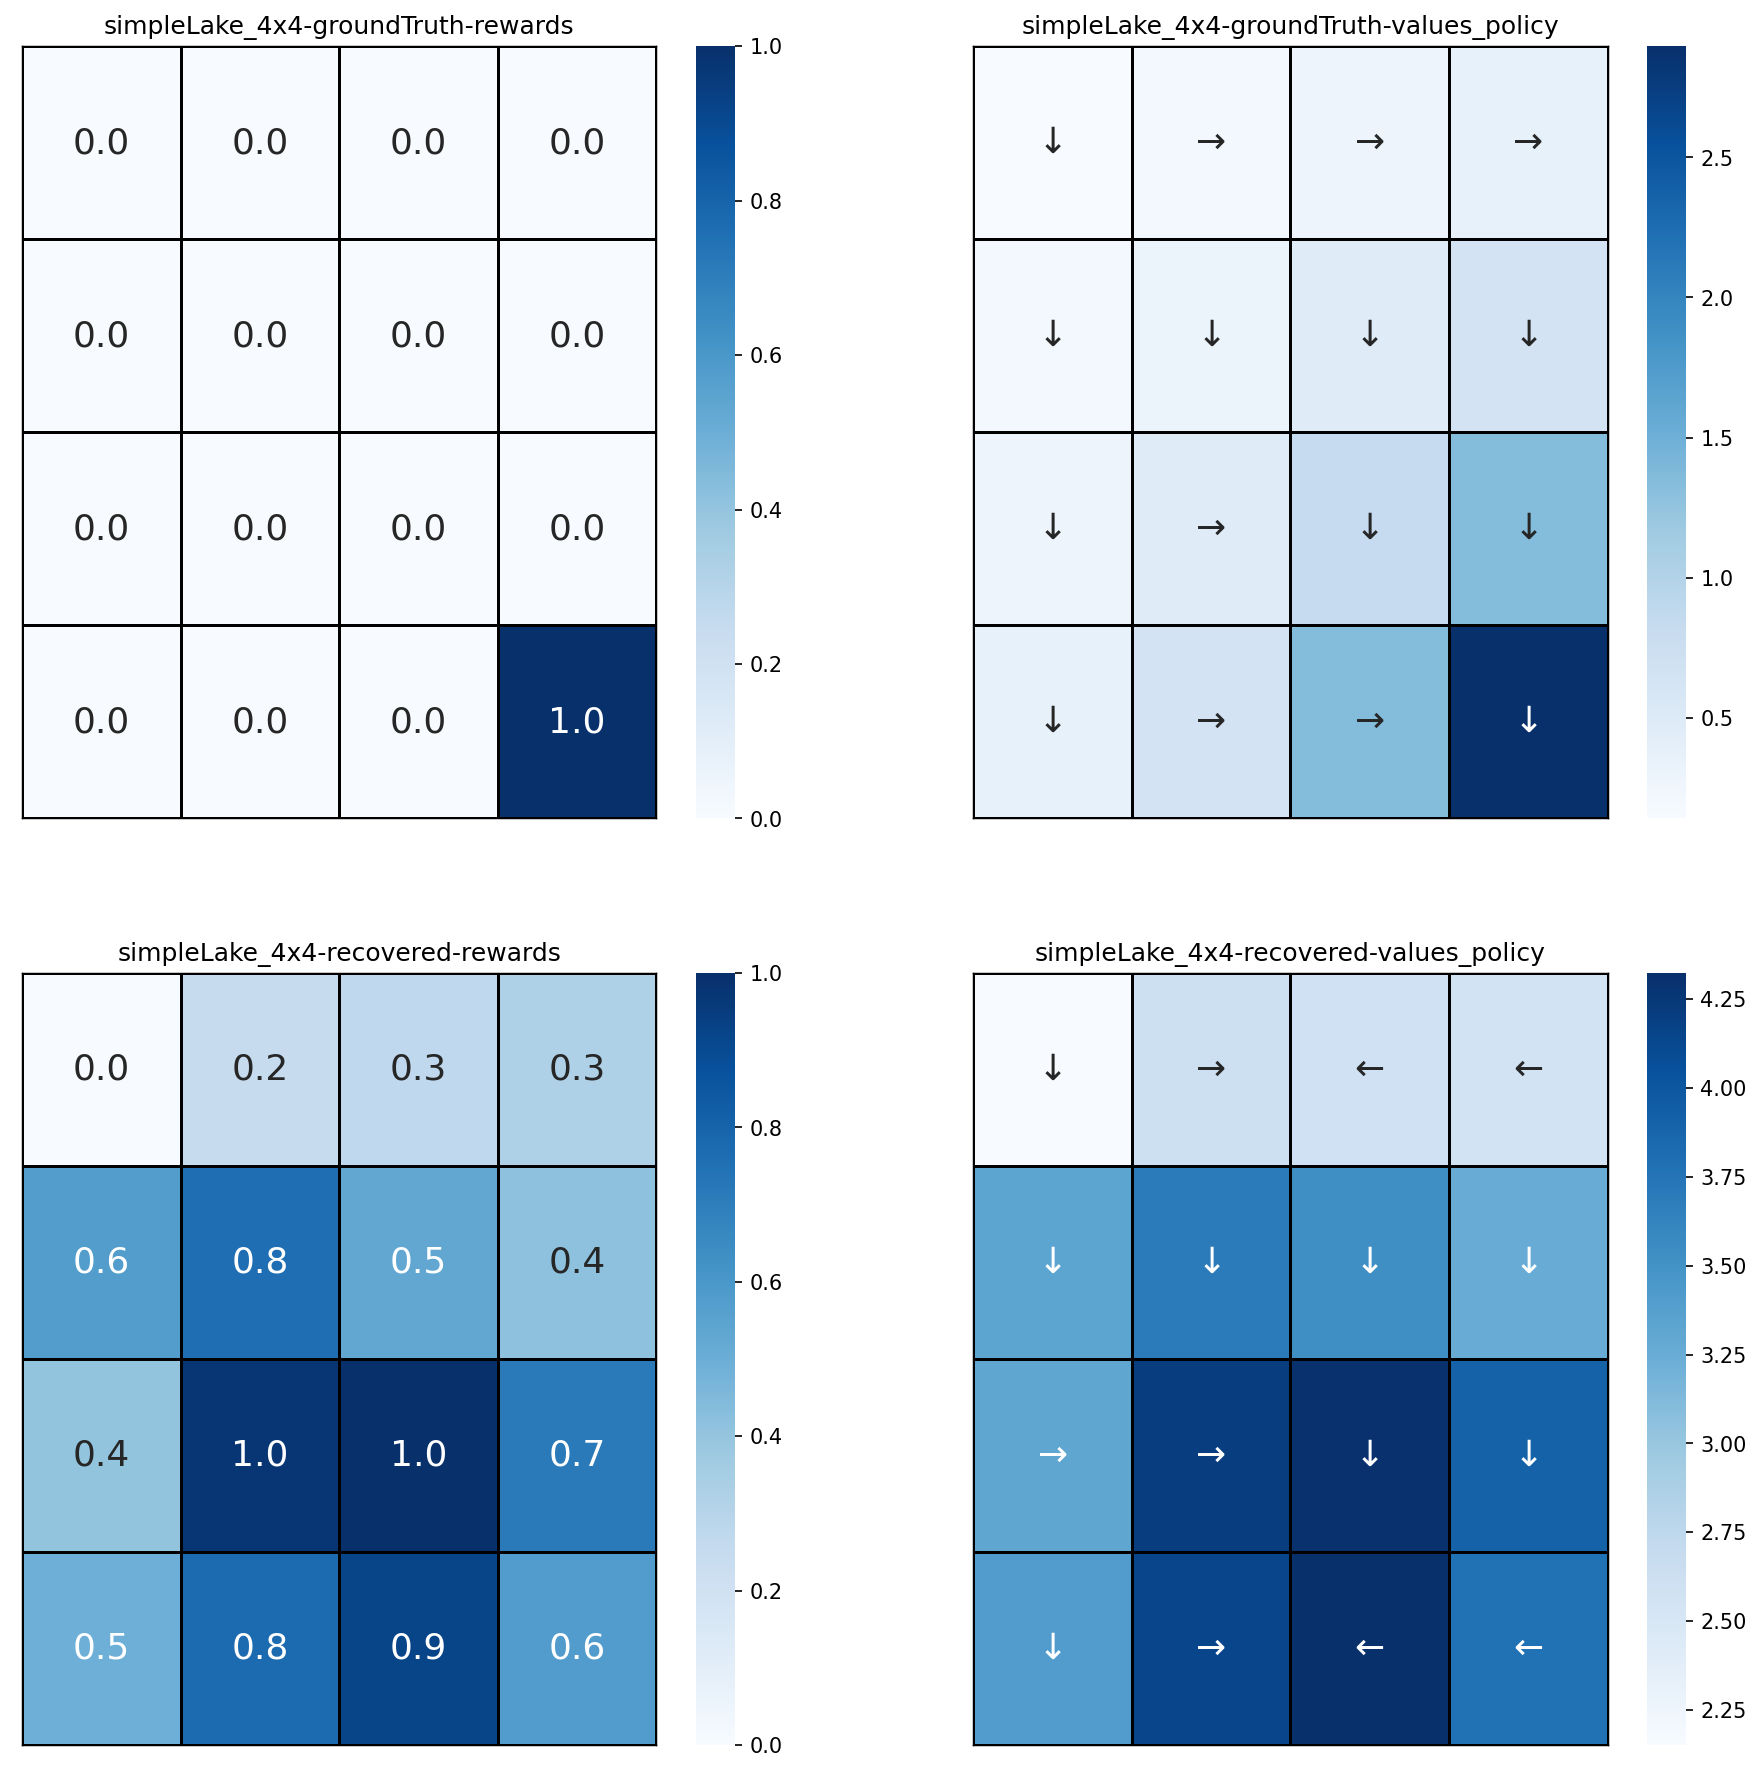

In [6]:
H = 4
W = 4
rmap_gt = np.zeros([H, W])
rmap_gt[H-1, W-1] = +1
ACT_RAND = 0.3
terminals = {(H-1, W-1)}
fl = frozenlake.FrozenLake(rmap_gt, terminals, 1 - ACT_RAND)
title = "simpleLake"
main(rmap_gt, fl, title, RAND_START=False, N_TRAJS=10000, N_ITERS=1000, order='C')

['SFFF', 'HFFH', 'FFHF', 'FFFG']


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:47<00:00,  9.28it/s]


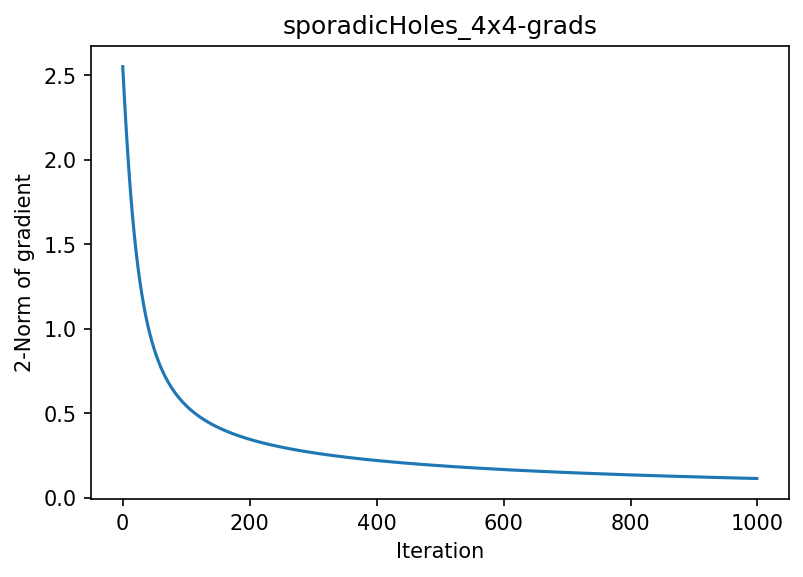

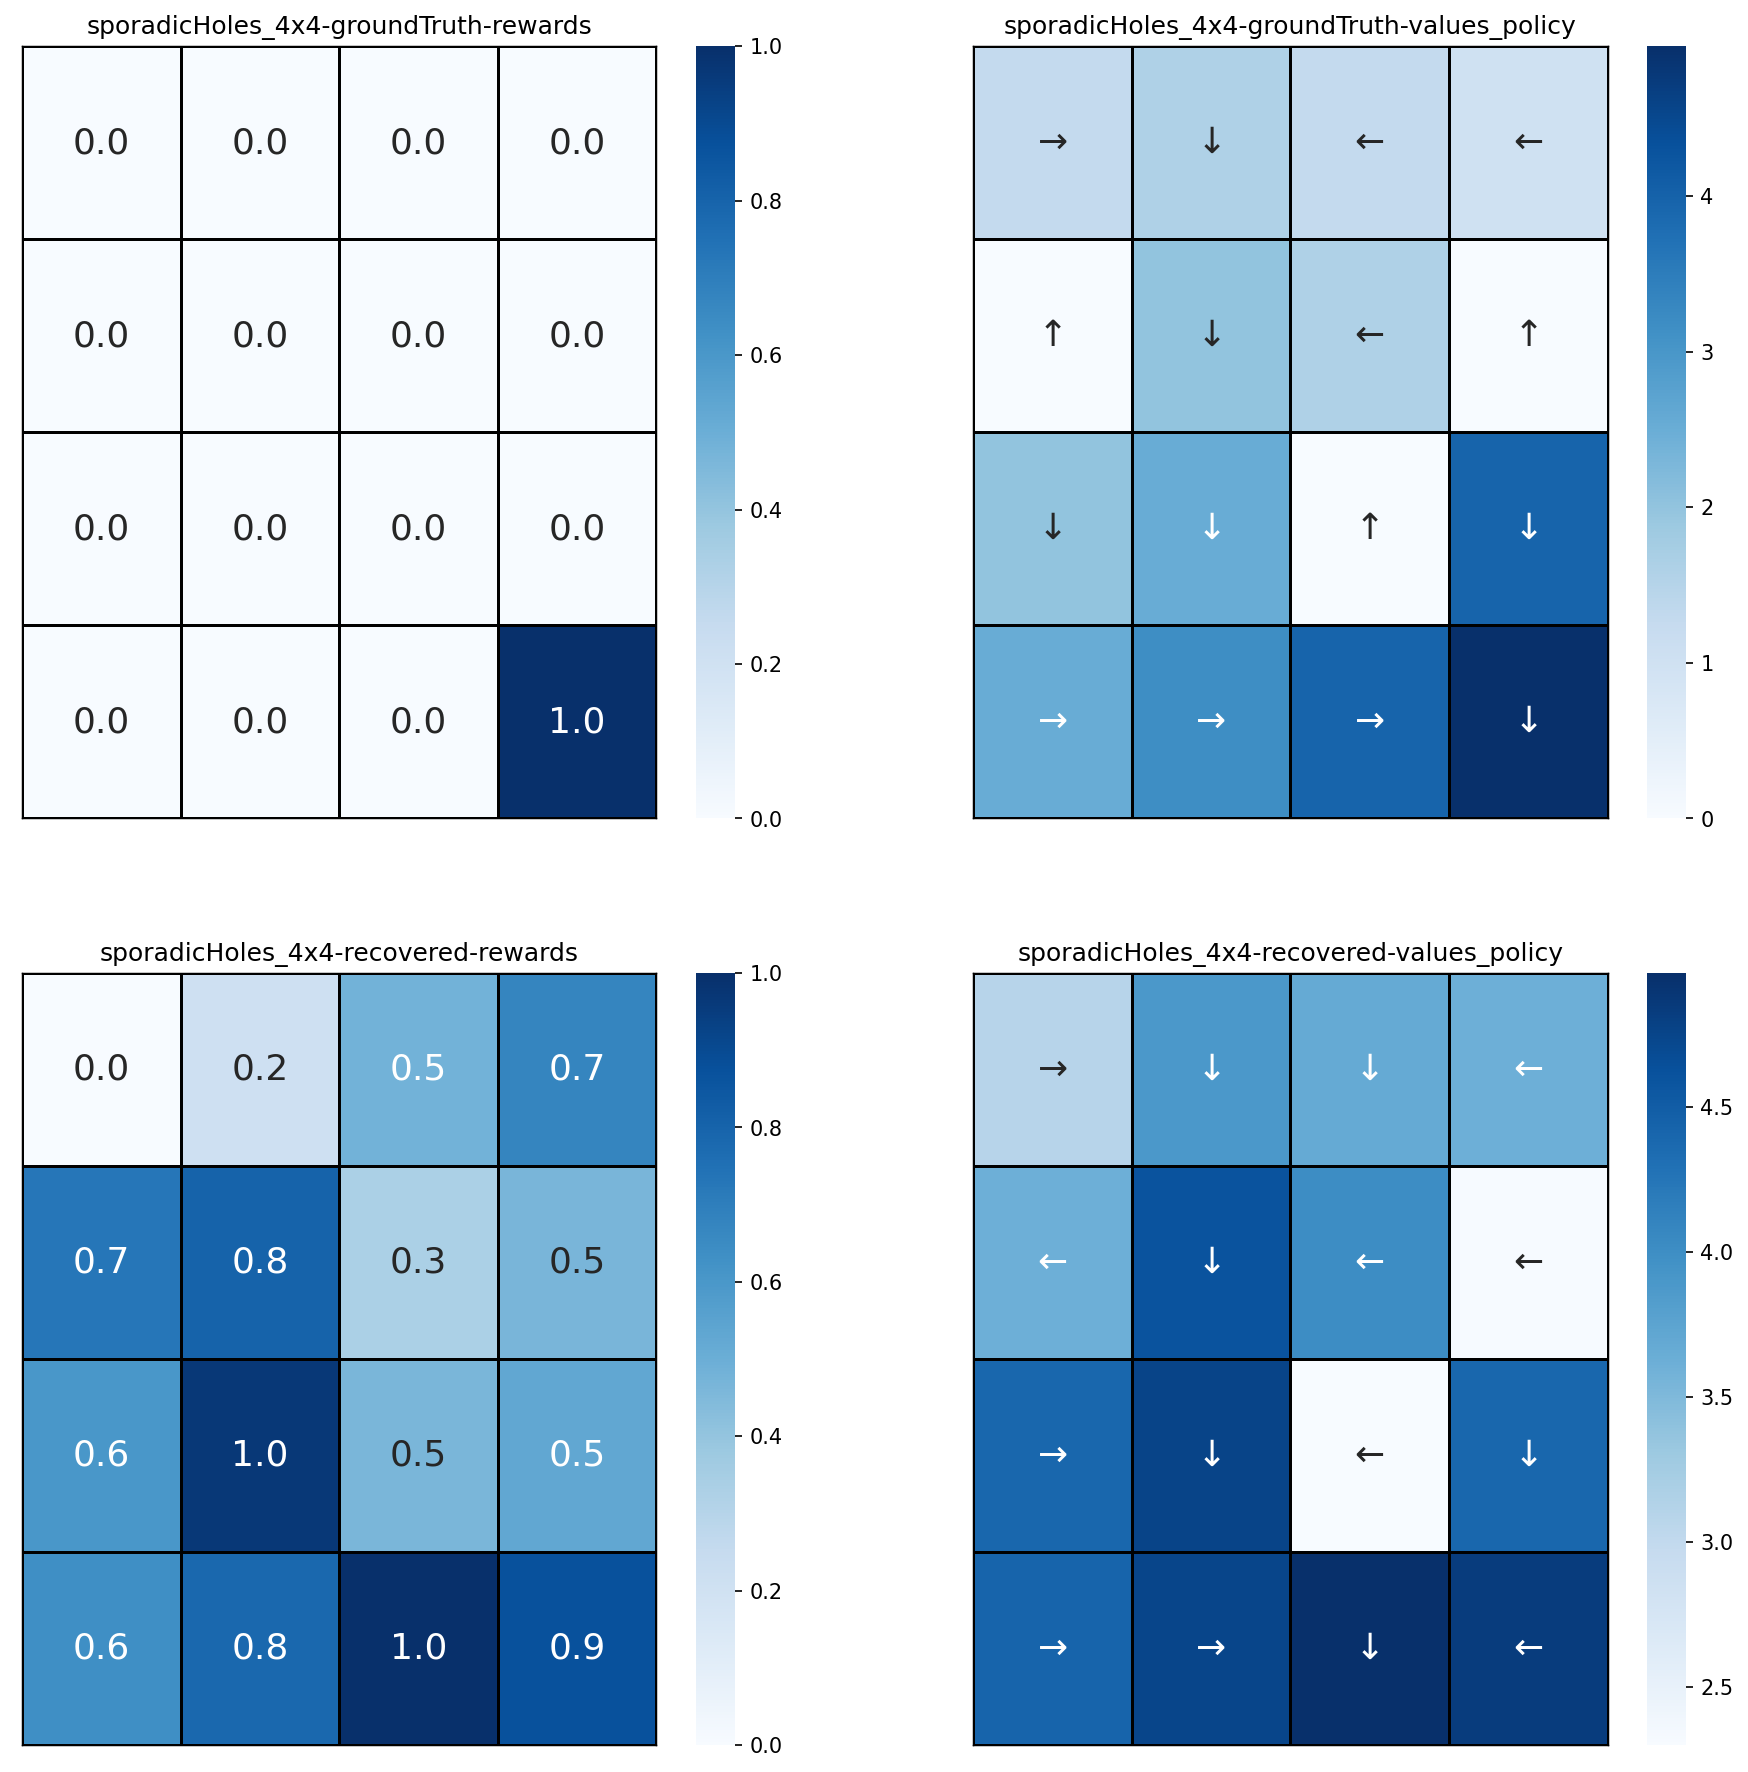

In [7]:
H = 4
W = 4
rmap_gt = np.zeros([H, W])
rmap_gt[H-1, W-1] = +1
holes = [(H-2, W-2), (H-3, W-1), (1, 0)]
for hole in holes:
    rmap_gt[hole[0]][hole[1]] = -1
ACT_RAND = 0
terminals = {(H-1, W-1), (H-2, W-2), (H-3, W-1), (1, 0)}
fl = frozenlake.FrozenLake(rmap_gt, terminals, 1 - ACT_RAND)
for hole in holes:
    rmap_gt[hole[0]][hole[1]] = 0
title = "sporadicHoles"
main(rmap_gt, fl, title, RAND_START=False, N_TRAJS=10000, N_ITERS=1000, order='C')

['SFFFFFFF', 'FFFFFFFF', 'FFFFFFFF', 'FFFFFFFF', 'FFFFFFFF', 'FFFFFFFH', 'FFFFFFHF', 'FFFFFFFG']


 32%|█████████████████████████▎                                                     | 642/2000 [14:21<30:01,  1.33s/it]C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 32%|█████████████████████████▍                                                     | 643/2000 [14:23<31:11,  1.38s/it]C:\Users\ASUS\Desktop\project\maxent-gw\maxent_irl.py:58: RuntimeWarning: overflow encountered in double_scalars
  z_aij[s, a] = sum([P_a[s, k, a]*np.exp(rewards[s])*z_si[k] for k in range(N_STATES)])
C:\Users\ASUS\Desktop\project\maxent-gw\maxent_irl.py:69: RuntimeWarning: invalid value encountered in double_scalars
  policy[s, a] = z_aij[s, a] / z_si[s]
100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [44:21<00:00,  1.33s/it]


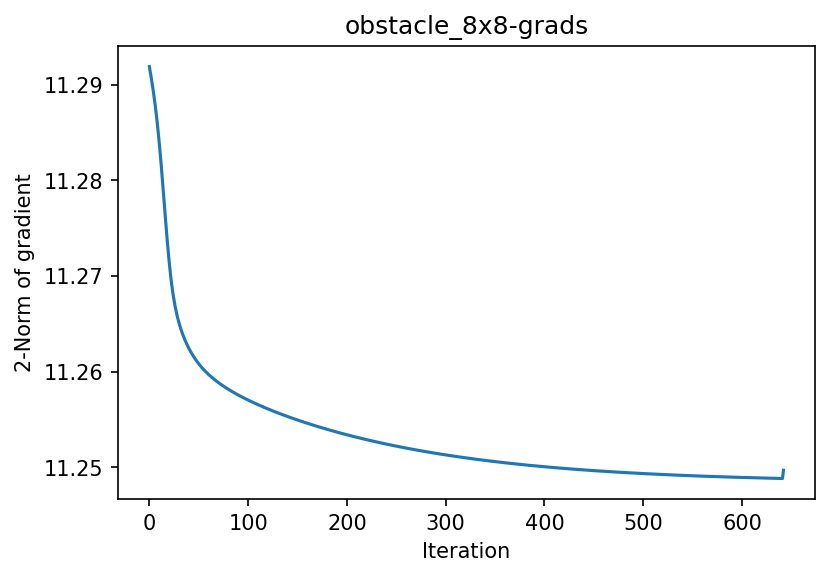

KeyboardInterrupt: 

In [5]:
H = 8
W = 8
rmap_gt = np.zeros([H, W])
rmap_gt[H-1, W-1] = +1
holes = [(H-2, W-2), (H-3, W-1)]
for hole in holes:
    rmap_gt[hole[0]][hole[1]] = -1
ACT_RAND = 0.3
terminals = {(H-1, W-1), (H-2, W-2), (H-3, W-1)}
fl = frozenlake.FrozenLake(rmap_gt, terminals, 1 - ACT_RAND)
for hole in holes:
    rmap_gt[hole[0]][hole[1]] = 0
title = "obstacle"
main(rmap_gt, fl, title, N_TRAJS=10000, N_ITERS=2000, order='C')